By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook analyses the accuracy of affinity predictions when using structures folded by AlphaFold.

In [1]:
# General imports
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.torch_utils import load_checkpoint

# Loading all the test samples (original and predicted with AlphaFold)

In [2]:
modes = 30
n_filters = 3
filter_size = 5
pooling_size = 2
n_max_epochs = 159

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

test_pdbs = ['2nz9', '5vpg', '6a0z', '4ffz', '5dd0', '3u0t', '1zv5', '4w6w', '3l95', '1oay', '1m7d', '2hkf', '5alb', '2p44', '4jan', '4odx']
h_offset_list = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
l_offset_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0]
original_structures = []
af_pred_structures = []

for test_pdb, h_offset, l_offset in zip(test_pdbs, h_offset_list, l_offset_list):
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, mode=mode, stage=stage, regions=regions, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb, alphafold=False)
    original_structures.append(preprocessed_data.test_x)
    
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, mode=mode, stage=stage, regions=regions, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb+'_af', alphafold=True, h_offset=h_offset, l_offset=l_offset)
    af_pred_structures.append(preprocessed_data.test_x)
    
input_shape = preprocessed_data.test_x.shape[-1]

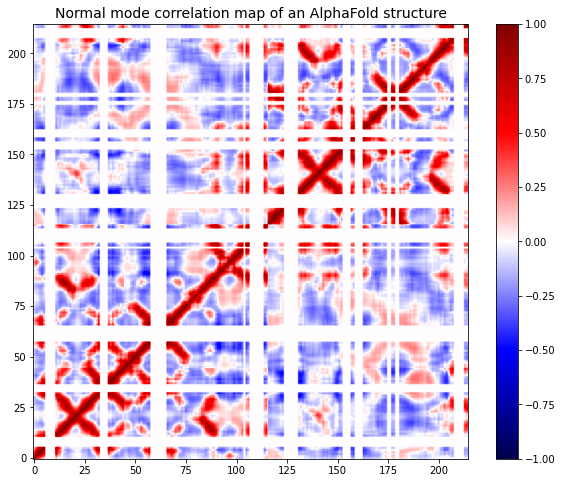

In [3]:
title_size = 20
font_size = 14

fig = plt.figure(figsize=(10, 8))
plt.imshow(preprocessed_data.test_x, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Normal mode correlation map of an AlphaFold structure', size=font_size)
plt.colorbar()
plt.show()

# Loading an ANTIPASTI checkpoint

In [4]:
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=33075, out_features=1, bias=False)
)

# Predicting the binding affinity

In [5]:
# We convert to the torch format and predict
kds_original = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in original_structures]
kds_af_pred = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in af_pred_structures]
corr_coeff = np.corrcoef(kds_original, kds_af_pred)[1,0]

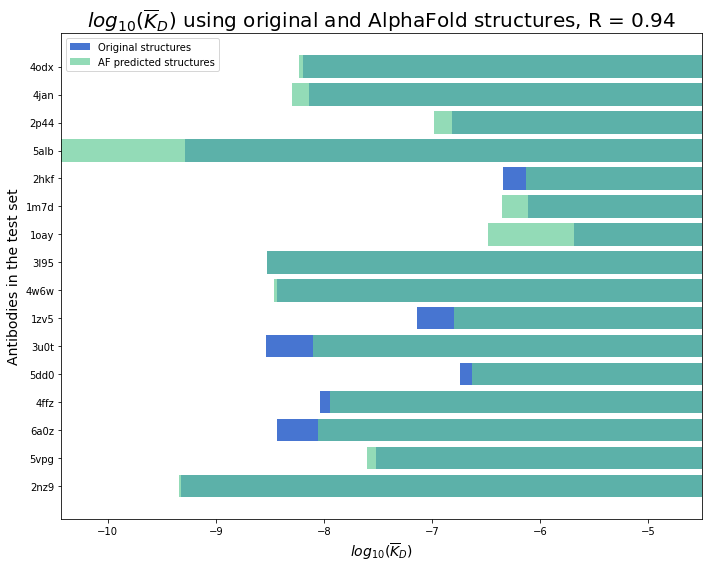

In [6]:
# Horizontal bar chart
fig = plt.figure(figsize=(10, 8))
y_pos = np.arange(len(test_pdbs))
plt.barh(y_pos, kds_original, align='center', alpha=0.9, label='Original structures', color='#3366cc')
plt.barh(y_pos, kds_af_pred, align='center', alpha=0.7, label='AF predicted structures', color='#66cc99')

# Add labels, title, and legend
plt.xlabel('$log_{10}(\overline{K}_D)$', size=font_size)
plt.ylabel('Antibodies in the test set', size=font_size)
plt.title('$log_{10}(\overline{K}_D)$ using original and AlphaFold structures, R = '+str(round(corr_coeff, 2)), size=title_size)
plt.yticks(y_pos, test_pdbs)
plt.legend()
plt.tight_layout()

# x-axis going from the minimum to -4.5
min_kd = min(min(kds_original), min(kds_af_pred))
plt.xlim(min_kd, -4.5)

plt.show()

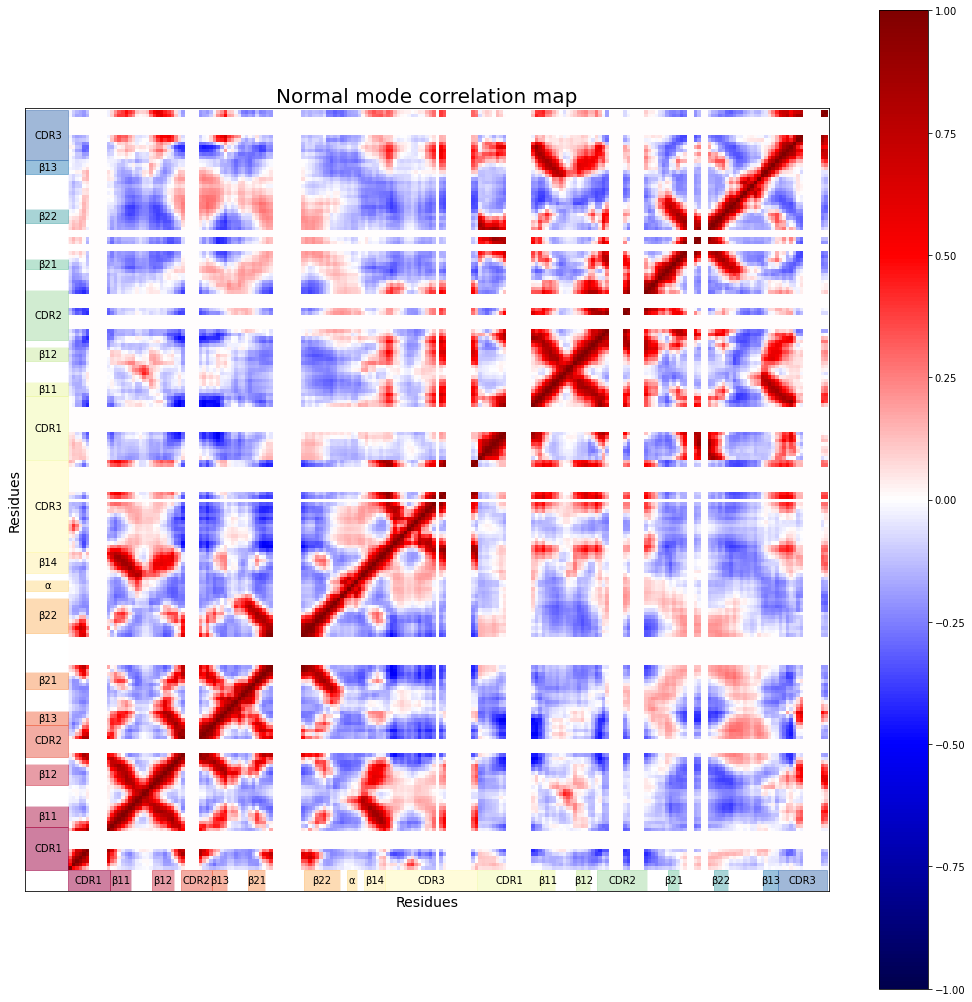

In [12]:
# Define the subgroup boundaries
mrlh = preprocessed_data.max_res_list_h
mrll = preprocessed_data.max_res_list_l
subgroup_boundaries_h = [mrlh.index('26'), mrlh.index('33'), mrlh.index('39'), mrlh.index('45'), mrlh.index('51'),
                       mrlh.index('52'), mrlh.index('57'), mrlh.index('61'), mrlh.index('67'), mrlh.index('72'),
                       mrlh.index('75'), mrlh.index('82'), mrlh.index('84'), mrlh.index('87'), mrlh.index('89'),
                       mrlh.index('95'), mrlh.index('102')+1]
subgroup_boundaries_l = [mrll.index('24'), mrll.index('34'), mrll.index('38'), mrll.index('44'), mrll.index('48'),
                       mrll.index('50'), mrll.index('56'), mrll.index('62'), mrll.index('65'), mrll.index('71'),
                       mrll.index('75'), mrll.index('85'), mrll.index('89'), mrll.index('97')+1]
labels_h = ['CDR1', '\u03B211', '', '\u03B212', '', 'CDR2', '\u03B213', '', '\u03B221', '', '\u03B222',
          '', '\u03B1', '', '\u03B214', 'CDR3', '']
labels_l = ['CDR1', '\u03B211', '', '\u03B212', '', 'CDR2', '', '\u03B221', '', '\u03B222',
          '', '\u03B213', 'CDR3']

subgroup_boundaries = subgroup_boundaries_h + [x+mrlh.index('102')+1 for x in subgroup_boundaries_l]
labels = labels_h + labels_l
fig = plt.figure(figsize=(18, 18))

# Plot the correlation matrix
plt.imshow(preprocessed_data.test_x, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

cmap = plt.get_cmap('Spectral')

for i in range(len(subgroup_boundaries) - 1):
    start_index = subgroup_boundaries[i]
    end_index = subgroup_boundaries[i + 1]
    label_position = (start_index + end_index) / 2 - 0.5
    
    # Choosing the colours
    if labels[i] != '':
        c = cmap(i / len(subgroup_boundaries))
    else:
        c = 'white'
        
    # Adding the rectangles
    rect = plt.Rectangle((start_index - 0.5, -6.5), end_index - start_index, 6,
                         edgecolor=c, facecolor=c, alpha=0.5)
    plt.gca().add_patch(rect)

    rect = plt.Rectangle((-12.5, start_index - 0.5), 12, end_index - start_index,
                         edgecolor=c, facecolor=c, alpha=0.5)
    plt.gca().add_patch(rect)

    # Add labels for the subgroups on the y-axis
    plt.text(-6, label_position, labels[i], ha='center', va='center', color='black')
    # Add labels for the subgroups on the x-axis
    plt.text(label_position, -3.5, labels[i], ha='center', va='center', color='black')
    
# Adjust the axis limits and labels
plt.xlim(-12.5, 215)
plt.ylim(-6.5, 215)
plt.xticks([])
plt.yticks([])

# Add labels and title
plt.xlabel('Residues', size=font_size)
plt.ylabel('Residues', size=font_size)
plt.title('Normal mode correlation map', size=title_size)


# Display the plot
plt.show()